In [1]:
import pyEDM as edm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from parse_data import *
from ts_alignment import *
from ts_prediction import *
from feature_selection import *
from collect_predictions import *

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 18
plt.rcParams["figure.figsize"] = (12, 7)

### Получение предсказаний (можно пропустить эту часть)

In [17]:
for SUBDIR in SUBDIRS:
    # parsing data from accelerometer and hyroscope
    dev_filename = f"./signals/{SUBDIR}.json"
    devices_data = parse_devices(dev_filename)
    
    # parsing data from video
    vid_filename = f"./encoded_video/{SUBDIR}.json"
    video_data = parse_video(vid_filename, KEYPOINTS_CNT)
    
    # alignment of time series
    cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
    small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)
    
    libsize = 700 if SUBDIR.startswith("chaotic") else 420
    predsize = 100 if SUBDIR.startswith("chaotic") else 60
    
    # CCM feature extraction and ts prediction
    extra_feat_inds = ccm_feat_selection(libsize=libsize, 
                                         k_feat_to_select=4, 
                                         devices_data=cut_devices_data, 
                                         video_data=video_data, 
                                         read_result=True, 
                                         filename=f"./preds/{SUBDIR}/ccm/small_corr_mat.txt")
    ccm_predict_ts(small_data, 
                   extra_feat_inds, 
                   libsize, 
                   predsize, 
                   Tp=1, 
                   subdir=SUBDIR)

    # PLS feature extraction and ts prediction
    pls_video = pls_feat_selection(libsize, 
                                   k_feat_to_select=4,                                   
                                   devices_data=cut_devices_data, 
                                   video_data=video_data)
    linear_predict_ts(pls_video, 
                      cut_devices_data, 
                      libsize, 
                      predsize, 
                      Tp=1, 
                      subdir=SUBDIR, 
                      latent_mode="pls")

    # CCA feature extraction and ts prediction
    cca_video = cca_feat_selection(libsize, 
                                   k_feat_to_select=4, 
                                   devices_data=cut_devices_data, 
                                   video_data=video_data)
    linear_predict_ts(cca_video, 
                      cut_devices_data, 
                      libsize, 
                      predsize, 
                      Tp=1, 
                      subdir=SUBDIR, 
                      latent_mode="cca")
    
    # Simple ts prediction
    naive_predict_ts(small_data, 
                     libsize, 
                     predsize, 
                     Tp=1, 
                     subdir=SUBDIR)

/home/eduard/paper_experiment/parse_data.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_data.drop(columns=['sensor'], inplace=True)
/home/eduard/paper_experiment/parse_data.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gyr_data.drop(columns=['sensor'], inplace=True)
/home/eduard/paper_experiment/ts_alignment.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cu

### Построение графиков

target: 0.0
ccm: 0.33927002060000006
pls: 0.38954195129999997
cca: 0.4122344711
naive: 0.29671392230000004


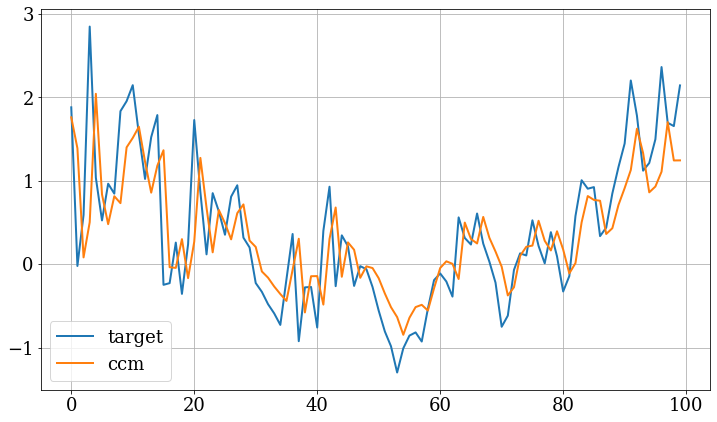

In [36]:
chaotic_preds = collect_pred_from_diff_methods('chaotic_1', 'acc_x')
chaotic_values = chaotic_preds.values

for i in range(chaotic_preds.shape[1]):
    print(f"{chaotic_preds.columns[i]}:", np.mean(np.square(chaotic_values[:, i] - chaotic_values[:, 0])))

plt.figure()
plt.plot(chaotic_preds['target'].values, label="target")
plt.plot(chaotic_preds['ccm'].values, label='ccm')

plt.grid(True)
plt.legend()
plt.show()

In [42]:
for SUBDIR in SUBDIRS:
    for TARGET in TARGET_COLUMNS:
        preds = collect_pred_from_diff_methods(SUBDIR, TARGET)

        for col in preds.columns[1:]:
            fig = plt.figure(figsize=(15, 9))
            plt.plot(preds['target'].values, label="target")
            plt.plot(preds[col].values, label=col)

            plt.grid(True)
            plt.legend()
            plt.close(fig)
            plt.savefig(f"images/{SUBDIR}/{TARGET}/{col}.png");

<Figure size 864x504 with 0 Axes>

### Отрисовка графиков с презентации

In [10]:
SUBDIR = "cyclic_2"
main_target_ind = 0
main_target = TARGET_COLUMNS[main_target_ind]
# parsing data from accelerometer and hyroscope
dev_filename = f"./signals/{SUBDIR}.json"
devices_data = parse_devices(dev_filename)

# parsing data from video
vid_filename = f"./encoded_video/{SUBDIR}.json"
video_data = parse_video(vid_filename, KEYPOINTS_CNT)

# alignment of time series
cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)

libsize = 700 if SUBDIR.startswith("chaotic") else 420
predsize = 100 if SUBDIR.startswith("chaotic") else 60

# CCM feature extraction and ts prediction
extra_feat_inds = ccm_feat_selection(libsize=libsize, 
                                     k_feat_to_select=4, 
                                     devices_data=cut_devices_data, 
                                     video_data=video_data, 
                                     read_result=True, 
                                     filename=f"./preds/{SUBDIR}/ccm/small_corr_mat.txt")

/home/eduard/paper_experiment/parse_data.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_data.drop(columns=['sensor'], inplace=True)
/home/eduard/paper_experiment/parse_data.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gyr_data.drop(columns=['sensor'], inplace=True)
/home/eduard/paper_experiment/ts_alignment.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cu

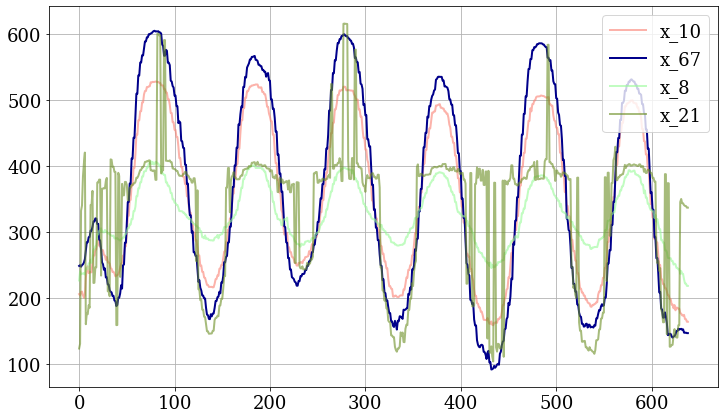

In [34]:
plt.figure()

colors = ("salmon", "darkblue", "palegreen", "olivedrab")

for ind, color in zip([20, 134, 16, 42], colors):
    alpha = 1 if color == "darkblue" else 0.6
    
    plt.plot(video_data.iloc[:, ind].values, 
             label=video_data.columns[ind], 
             color=color,
             alpha=alpha)
    
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("images/source_ts_example.png")

/tmp/ipykernel_22546/550876130.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


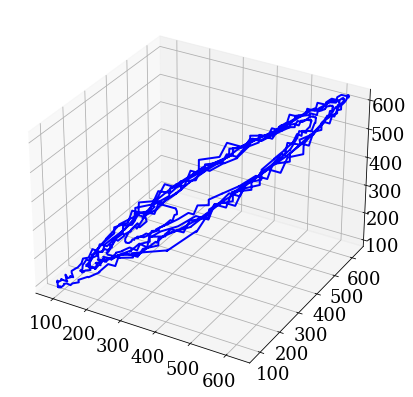

In [133]:
embed_source = edm.Embed(dataFrame=video_data.iloc[:, :], 
                         columns=video_data.columns[extra_feat_inds[main_target_ind, 2]], 
                         tau=-2,
                         E=3)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(embed_source.iloc[:, 0].values,
        embed_source.iloc[:, 1].values, 
        embed_source.iloc[:, 2].values, 
        color = "blue")
plt.savefig("images/3d_source.png")

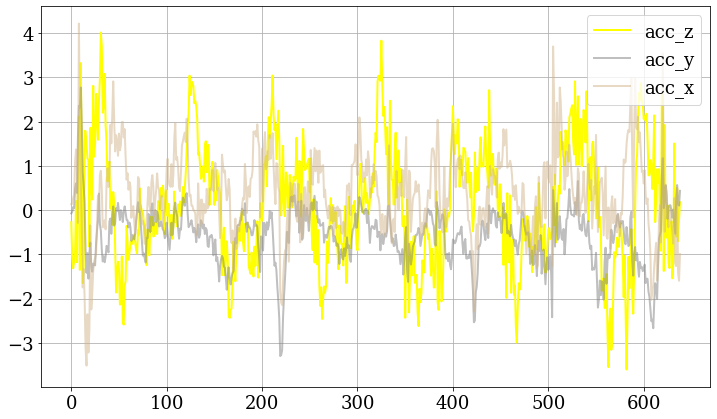

In [134]:
plt.figure()

colors = ("yellow", "gray", "tan")

for target, color in zip(TARGET_COLUMNS[:3], colors):
    alpha = 1 if target == main_target else 0.5
    
    plt.plot(cut_devices_data[target].values, 
             color=color, 
             label=target, 
             alpha=alpha)

plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("images/target_ts_example.png")

/tmp/ipykernel_22546/3048983359.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


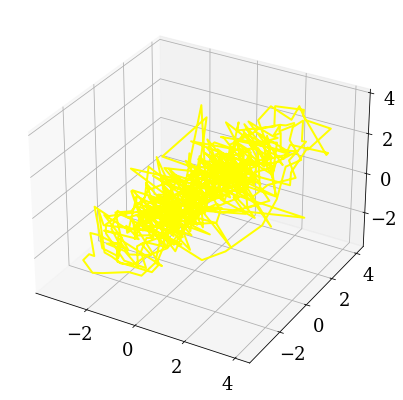

In [135]:
embed_target = edm.Embed(dataFrame=cut_devices_data.iloc[:, :], 
                         columns=[main_target], 
                         tau=-2,
                         E=3)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(embed_target.iloc[:, 0].values,
        embed_target.iloc[:, 1].values, 
        embed_target.iloc[:, 2].values, 
        color = "yellow")

plt.savefig("images/3d_target.png")